In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv


Credit Risk Analysis:

Credit risk can be defined as the risk associated to the financial lost that resulted from failure in loan repayment by the borrower. 
Creditors or lenders need to minimize the risk in order to prevent cash flow interruption or incur additional cost to collect the defaulted loan.
Hence, conducting credit risk analysis based on history data is crucial before granting any loan. 

Data Source: https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clientsabs

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.


Some ideas for exploration:

How does the probability of default payment vary by categories of different demographic variables?
Which variables are the strongest predictors of default payment?

In [1]:
#lib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, KFold, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, confusion_matrix
from xgboost import XGBClassifier
from sklearn.svm import SVC

from collections import Counter
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


There are 25 variables:

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment (1=yes, 0=no)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [7]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [8]:
#no missing values
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [3]:
#dropping ID column
df = df.drop(['ID'] , axis = 1)
df.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [10]:
#correlation with the defaulter status
#bill_amt - bill_amt5
df.corr()['default.payment.next.month']

LIMIT_BAL                    -0.153520
SEX                          -0.039961
EDUCATION                     0.028006
MARRIAGE                     -0.024339
AGE                           0.013890
PAY_0                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
BILL_AMT1                    -0.019644
BILL_AMT2                    -0.014193
BILL_AMT3                    -0.014076
BILL_AMT4                    -0.010156
BILL_AMT5                    -0.006760
BILL_AMT6                    -0.005372
PAY_AMT1                     -0.072929
PAY_AMT2                     -0.058579
PAY_AMT3                     -0.056250
PAY_AMT4                     -0.056827
PAY_AMT5                     -0.055124
PAY_AMT6                     -0.053183
default.payment.next.month    1.000000
Name: default.payment.next.month, dtype: float64

### EDA

In [11]:
#class balance
# no default 77% - class imbalance
df['default.payment.next.month'].value_counts(normalize=True) * 100

default.payment.next.month
0    77.88
1    22.12
Name: proportion, dtype: float64

Pay_0 Repayment status in September, 2005 Distribution:
- Overall, max count is for pay_0 = 1 that is payment delay for one month. pay_0 = 0 or -1 means duly payment
- For defaulters, max count is for duly payment , followed by 2 month delay.

In [12]:
# 'PAY_0' to PAY_6
#erepayment status in September, 2005 
#(-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)

#pay_0 to pay_6 repayement status sept, aug, july, june, may, apr
df['PAY_0'].value_counts()

PAY_0
 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: count, dtype: int64

In [13]:
fault = df[df['default.payment.next.month'] == 1]
no_fault =  df[df['default.payment.next.month'] == 0]
fault['PAY_0'].value_counts()

PAY_0
 0    1888
 2    1844
 1    1252
-1     954
-2     365
 3     244
 4      52
 5      13
 8      11
 7       7
 6       6
Name: count, dtype: int64

Gender Count:
- Overall, females 60% and makes 40%
- Defaulters, females 56%, makes 43%

In [14]:
#overall gender distribution 1: male, 2:female
df['SEX'].value_counts(normalize=True) * 100

SEX
2    60.373333
1    39.626667
Name: proportion, dtype: float64

In [15]:
#gender distribution for defaulters (1=male, 2=female)
fault['SEX'].value_counts(normalize=True) * 100

SEX
2    56.705847
1    43.294153
Name: proportion, dtype: float64

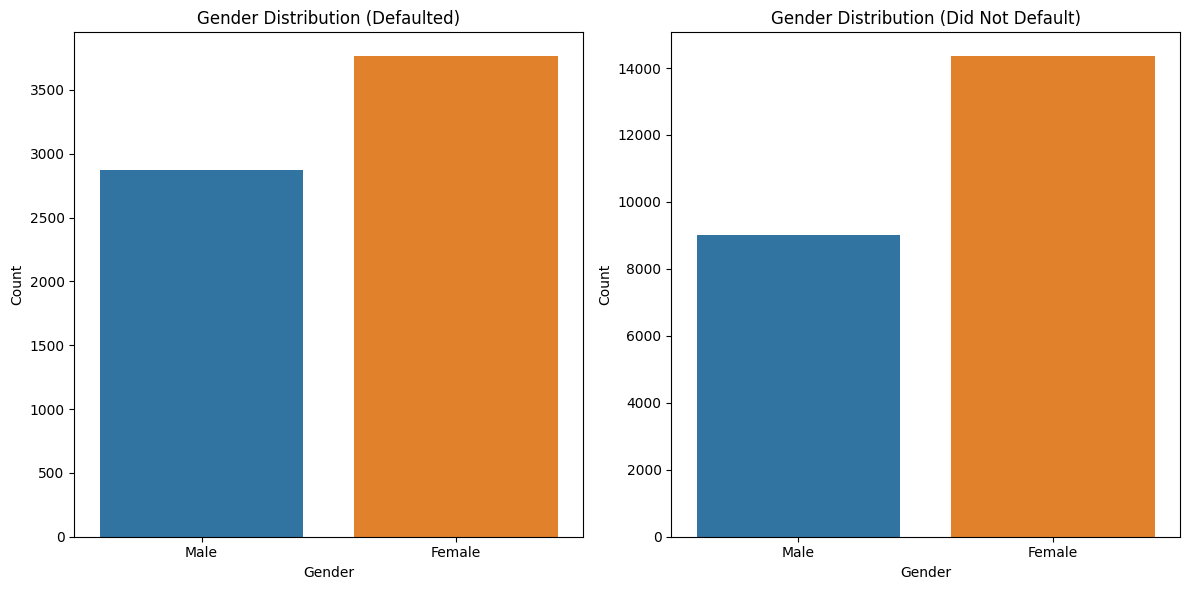

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for clients who defaulted
sns.countplot(x='SEX', data=fault, ax=ax[0])
ax[0].set_title('Gender Distribution (Defaulted)')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['Male', 'Female'])
ax[0].set_xlabel('Gender')
ax[0].set_ylabel('Count')

# Histogram for clients who did not default
sns.countplot(x='SEX', data=no_fault, ax=ax[1])
ax[1].set_title('Gender Distribution (Did Not Default)')
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Male', 'Female'])
ax[1].set_xlabel('Gender')
ax[1].set_ylabel('Count')

# Display plots
plt.tight_layout()
plt.show()

Education Distribution
- Overall, max university and graduate school
- Defaulters, max university and graduate school

In [17]:
#education (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown
df['EDUCATION'].value_counts(normalize=True) * 100

EDUCATION
2    46.766667
1    35.283333
3    16.390000
5     0.933333
4     0.410000
6     0.170000
0     0.046667
Name: proportion, dtype: float64

In [18]:
#for defaulters
#fault['EDUCATION'].replace({0: 'Unknown', 1:'Graduate School',2:'University',3:'High School',4:'Others',5:'Unknown',6:'Unknown'}, inplace=True)
fault.EDUCATION.value_counts(normalize=True) * 100

EDUCATION
2    50.180832
1    30.681133
3    18.640747
5     0.271248
6     0.120555
4     0.105485
Name: proportion, dtype: float64

In [4]:
#replace the unknown with 1 
df['EDUCATION'].replace({0:1,1:1, 2:2, 3:3, 4:4, 5:1 , 6:1} , inplace = True)
df.EDUCATION.value_counts(normalize = True) * 100

EDUCATION
2    46.766667
1    36.433333
3    16.390000
4     0.410000
Name: proportion, dtype: float64

Marriage Distribution
- Overall, max count for single followed by married
- Defaulters,  max count for single followed by married

In [20]:
#marriage: 1=married, 2=single, 3=others
#df['MARRIAGE'].replace({0: 'U', 1:'Married',2:'Single',3:'Others'}, inplace=True)
df.MARRIAGE.value_counts(normalize = True) * 100

MARRIAGE
2    53.213333
1    45.530000
3     1.076667
0     0.180000
Name: proportion, dtype: float64

In [21]:
#fault['MARRIAGE'].replace({0: 'U', 1:'Married',2:'Single',3:'Others'}, inplace=True)
fault.MARRIAGE.value_counts(normalize = True) * 100

MARRIAGE
2    50.346594
1    48.312236
3     1.265823
0     0.075347
Name: proportion, dtype: float64

In [5]:
#replace unknown with 1 
df['MARRIAGE'].replace({0:1 , 1:1, 2:2, 3:3} , inplace = True)
df.MARRIAGE.value_counts()

MARRIAGE
2    15964
1    13713
3      323
Name: count, dtype: int64

Age Distribution
- overall and Defaulters, max count 25- 35 year age group.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Age distribution')

<Figure size 600x600 with 0 Axes>

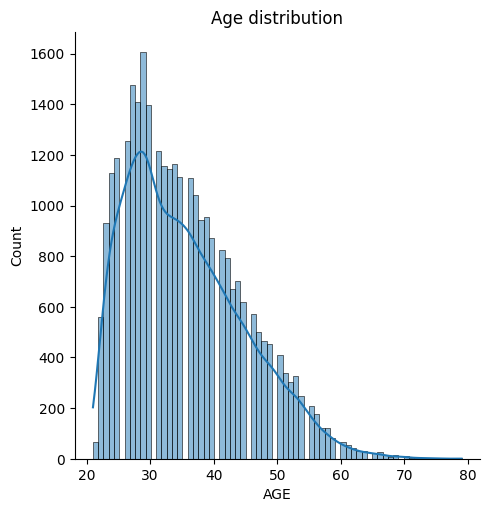

In [23]:
#age
#defaulters have age group between 25-30
plt.figure(figsize=(6,6))
sns.displot(df['AGE'], kde=True)
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title("Age distribution")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Age distribution')

<Figure size 600x600 with 0 Axes>

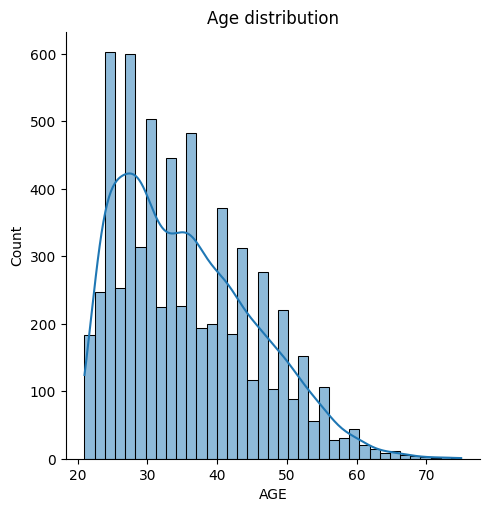

In [24]:
#age
#defaulters have age group between 25-30
plt.figure(figsize=(6,6))
sns.displot(fault['AGE'], kde=True)
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title("Age distribution")

Insights:
 For defaulters,
- Overall data has more number of females as compared to males.
For Default payment, higher for females as compares to males.
- Higher proportion of graduates and university (educated people)
- Higher proportion of singles as compared to married.



/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


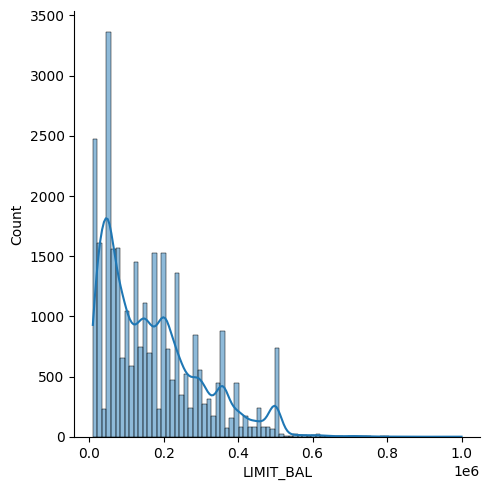

In [25]:
#LIMIT_BAL: Amount of given credit in NT dol
sns.displot(df.LIMIT_BAL, kde=True)

<ipython-input-26-e2ff3ef553b1>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(231)


Text(0, 0.5, 'BILL_AMT6')

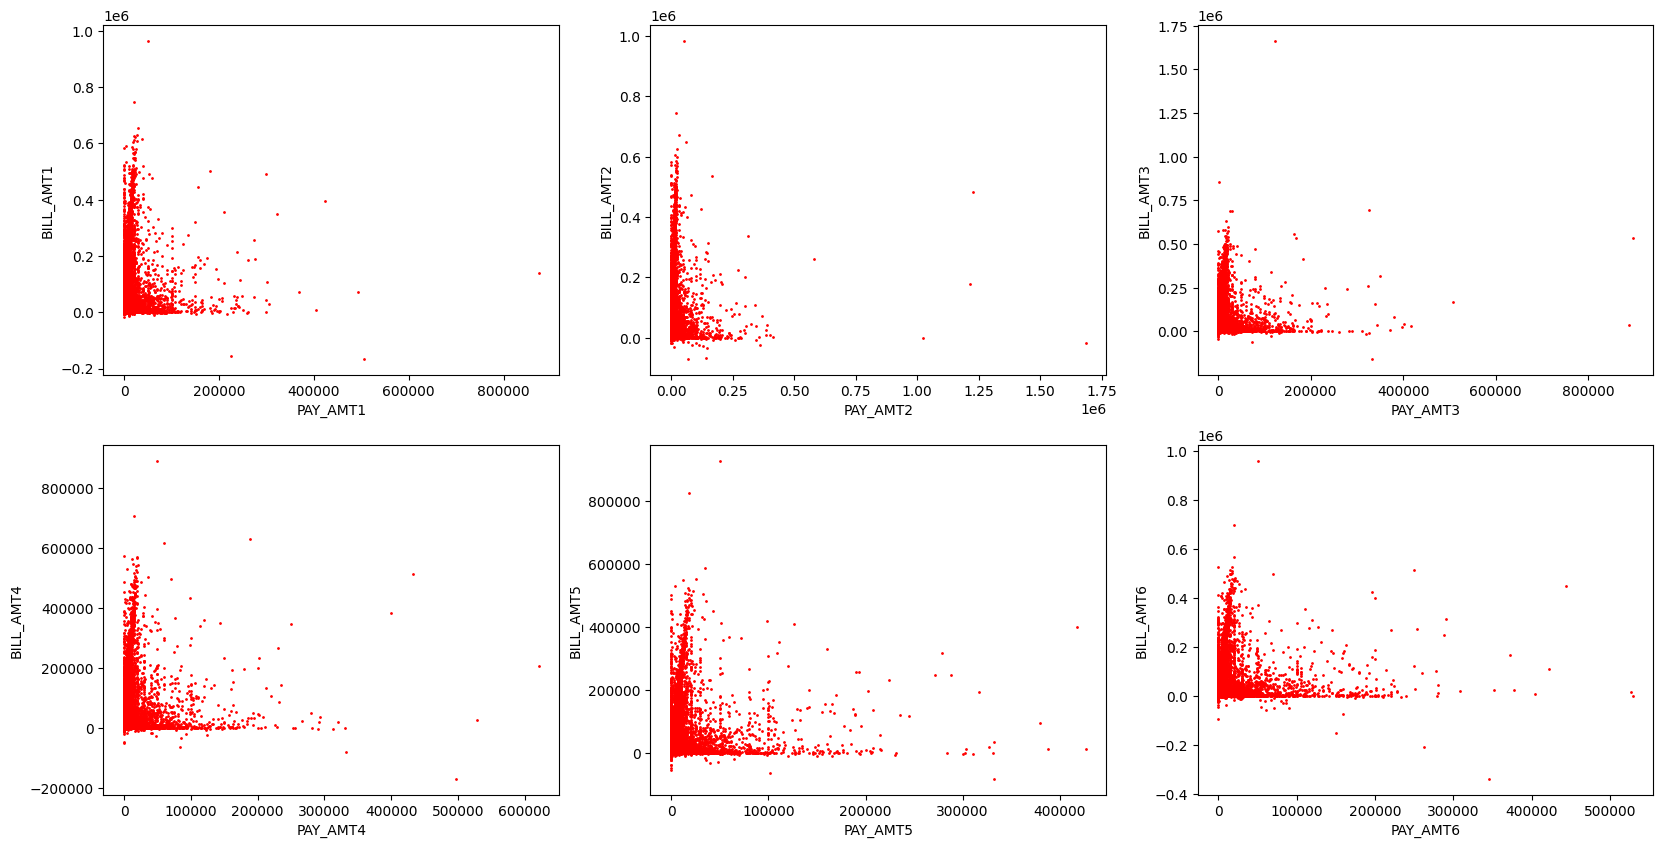

In [26]:
#bill_amt1 to amt6 amount of bill in spet, aug, july, hune, may , april
#pay_amt1 to pay_amt6: amount of previous payment
#aomunt of bill and amount paid in previous
plt.subplots(figsize=(20,10))
plt.subplot(231)
plt.scatter(x=df.PAY_AMT1, y=df.BILL_AMT1, c='r', s=1)
plt.xlabel('PAY_AMT1')
plt.ylabel('BILL_AMT1')

plt.subplot(232)
plt.scatter(x=df.PAY_AMT2, y=df.BILL_AMT2, c='r', s=1)
plt.xlabel('PAY_AMT2')
plt.ylabel('BILL_AMT2')

plt.subplot(233)
plt.scatter(x=df.PAY_AMT3, y=df.BILL_AMT3, c='r', s=1)
plt.xlabel('PAY_AMT3')
plt.ylabel('BILL_AMT3')


plt.subplot(234)
plt.scatter(x=df.PAY_AMT4, y=df.BILL_AMT4, c='r', s=1)
plt.xlabel('PAY_AMT4')
plt.ylabel('BILL_AMT4')

plt.subplot(235)
plt.scatter(x=df.PAY_AMT5, y=df.BILL_AMT5, c='r', s=1)
plt.xlabel('PAY_AMT5')
plt.ylabel('BILL_AMT5')


plt.subplot(236)
plt.scatter(x=df.PAY_AMT6, y=df.BILL_AMT6, c='r', s=1)
plt.xlabel('PAY_AMT6')
plt.ylabel('BILL_AMT6')

### Data Preprocessing

In [6]:
#input and target variable
X = df.drop(['default.payment.next.month'] , axis = 1)
y = df['default.payment.next.month']
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,2,2,2,26,-1,2,0,0,0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000.0,2,2,2,34,0,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,50000.0,2,2,1,37,0,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


In [19]:
#dropping the bull amoutn and pay amount columns
new_X = X.drop(['BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'] , axis = 1)
new_X

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2
1,120000.0,2,2,2,26,-1,2,0,0,0,2
2,90000.0,2,2,2,34,0,0,0,0,0,0
3,50000.0,2,2,1,37,0,0,0,0,0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,3,1,39,0,0,0,0,0,0
29996,150000.0,1,3,2,43,-1,-1,-1,-1,0,0
29997,30000.0,1,2,2,37,4,3,2,-1,0,0
29998,80000.0,1,3,1,41,1,-1,0,0,0,-1


In [7]:
#scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size = 0.2 , random_state = 42)

In [10]:
#class distribution before sampling
Counter(y_train)

Counter({0: 18677, 1: 5323})

In [8]:
#resampling
SMOTE = SMOTE()
X_train,y_train= SMOTE.fit_resample(X_train,y_train)

In [32]:
#class distribution after resampling using SMOTE
Counter(y_train)

Counter({0: 18677, 1: 18677})

### Bulding Model
- Logistic regression
- SVC
- Random Forest
- XGBoost

In [9]:
#roc_curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return None

Logistic Regression


In [34]:
#lr with grid search cv
folds = KFold(n_splits=5, shuffle=True, random_state=4)
params = {"C": [0.01, 0.1, 1, 10]}
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10]}, return_train_score=True,
             scoring='roc_auc', verbose=1)

In [35]:
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']
print(" The highest test roc_auc is {0} at C = {1}".format(best_score, best_C))

 The highest test roc_auc is 0.7289156742275775 at C = 10


In [36]:
#fit the model with the best params
log_model = LogisticRegression(C=10)
log_model = log_model.fit(X_train, y_train)

In [37]:
#evaluation metrics
y_pred = log_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
y_test_pred_proba = log_model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_test_pred_proba)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC-Score: {auc_score:.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.69      0.77      4687
           1       0.37      0.66      0.48      1313

    accuracy                           0.68      6000
   macro avg       0.63      0.68      0.63      6000
weighted avg       0.77      0.68      0.71      6000

Precision: 0.37
Recall: 0.66
F1-Score: 0.48
AUC-ROC-Score: 0.73


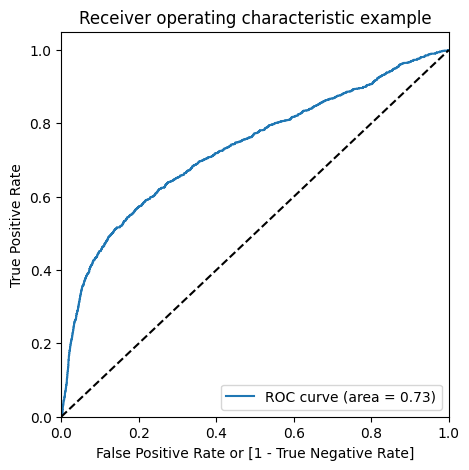

In [38]:
#roc curve
draw_roc(y_test, y_test_pred_proba)

Inference for LR:


RandomForest

In [40]:
#rf
rf_params = {
    "n_estimators": [100, 150, 200],
    "max_depth": [10, 15, 20]
    #"min_samples_split": [2, 5]
}

model_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=rf_params,
                           scoring='roc_auc',
                           cv=3,
                           verbose=3,
                           return_train_score=True)
model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END max_depth=10, n_estimators=100;, score=(train=0.928, test=0.811) total time=   4.7s
[CV 2/3] END max_depth=10, n_estimators=100;, score=(train=0.886, test=0.871) total time=   4.1s
[CV 3/3] END max_depth=10, n_estimators=100;, score=(train=0.889, test=0.860) total time=   4.1s
[CV 1/3] END max_depth=10, n_estimators=150;, score=(train=0.929, test=0.811) total time=   6.6s
[CV 2/3] END max_depth=10, n_estimators=150;, score=(train=0.885, test=0.871) total time=   6.1s
[CV 3/3] END max_depth=10, n_estimators=150;, score=(train=0.888, test=0.859) total time=   6.2s
[CV 1/3] END max_depth=10, n_estimators=200;, score=(train=0.929, test=0.811) total time=   8.8s
[CV 2/3] END max_depth=10, n_estimators=200;, score=(train=0.886, test=0.872) total time=   8.2s
[CV 3/3] END max_depth=10, n_estimators=200;, score=(train=0.889, test=0.860) total time=   8.2s
[CV 1/3] END max_depth=15, n_estimators=100;, score=(train=0.990, t

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15, 20],
                         'n_estimators': [100, 150, 200]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [41]:
rf_model = model_cv.best_estimator_
print("Best Random Forest AUC-ROC:", model_cv.best_score_)
print("Best Parameters:" , model_cv.best_params_)

Best Random Forest AUC-ROC: 0.9168651773716007
Best Parameters: {'max_depth': 20, 'n_estimators': 200}


In [42]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [43]:
y_pred = rf_model.predict(X_test)
y_test_pred_proba = rf_model.predict_proba(X_test)[:, 1]
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC-Score: {roc_auc_score(y_test, y_test_pred_proba):.2f}")


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      4687
           1       0.51      0.49      0.50      1313

    accuracy                           0.79      6000
   macro avg       0.69      0.68      0.68      6000
weighted avg       0.78      0.79      0.78      6000

AUC-ROC-Score: 0.76


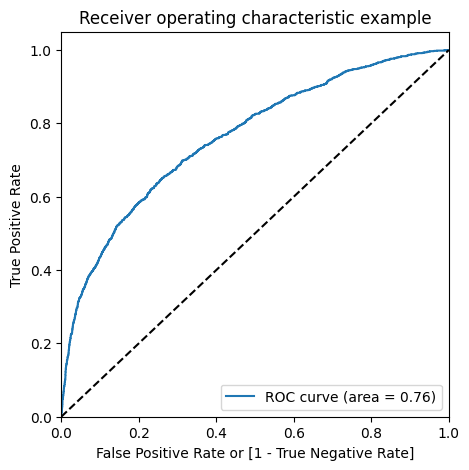

In [45]:
#roc curve
draw_roc(y_test, y_test_pred_proba)

XGBoost

In [27]:
xgb_params={
 "learning_rate"    : [0.15] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10],
 "min_child_weight" : [ 1, 3],
 "gamma"            : [ 0.0, 0.1, 0.2],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 ]
    
}
#gridSearchCV 
xgb_model_cv = GridSearchCV(estimator=XGBClassifier(),
                            param_grid=xgb_params,
                            scoring='roc_auc',
                            cv = 3,
                            verbose = 2,
                            return_train_score=True)
xgb_model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1; total time=   0.3s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=1; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=1; total time=   0.2s
[CV] END colsample_bytree

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5],
                         'gamma': [0.0, 0.1, 0.2], 'learning_rate': [0.15],
                         'max_depth': [3, 4, 5, 6, 8, 10],
                         'min_child_weight': [1, 3]},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [29]:
# Best parameters and model fitting
best_xgb = xgb_model_cv.best_estimator_
print("Best XGBoost AUC-ROC:", xgb_model_cv.best_score_)
best_xgb.fit(X_train, y_train)

Best XGBoost AUC-ROC: 0.9170481965968866


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [30]:
# Evaluation
xgb_y_pred = best_xgb.predict(X_test)
xgb_y_test_pred_proba = best_xgb.predict_proba(X_test)[:, 1]
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_y_pred))
print(f"AUC-ROC-Score: {roc_auc_score(y_test, xgb_y_test_pred_proba):.2f}")


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      4687
           1       0.55      0.40      0.47      1313

    accuracy                           0.80      6000
   macro avg       0.70      0.66      0.67      6000
weighted avg       0.78      0.80      0.79      6000

AUC-ROC-Score: 0.76


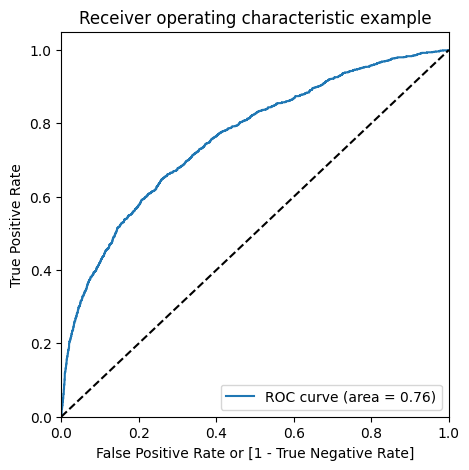

In [31]:
# ROC Curve
draw_roc(y_test, xgb_y_test_pred_proba)

SVC

In [11]:
svc_params = {
    "C": [0.1, 1, 10],
    "kernel": ['rbf']
}

#gridSearchCV for SVC
svc_model_cv = GridSearchCV(estimator=SVC(probability=True, random_state=42),
                            param_grid=svc_params,
                            scoring='roc_auc',
                            cv=3,
                            verbose=1,
                            return_train_score=True)
svc_model_cv.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3, estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['rbf']},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [12]:
#best parameters and model fitting
best_svc = svc_model_cv.best_estimator_
print("Best SVC AUC-ROC:", svc_model_cv.best_score_)
best_svc.fit(X_train, y_train)

Best SVC AUC-ROC: 0.8173520962335457


SVC(C=10, probability=True, random_state=42)

In [13]:
#evaluation
svc_y_pred = best_svc.predict(X_test)
svc_y_test_pred_proba = best_svc.predict_proba(X_test)[:, 1]
print("\nSVC Classification Report:")
print(classification_report(y_test, svc_y_pred))
print(f"AUC-ROC-Score: {roc_auc_score(y_test, svc_y_test_pred_proba):.2f}")


SVC Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      4687
           1       0.46      0.60      0.52      1313

    accuracy                           0.76      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.79      0.76      0.77      6000

AUC-ROC-Score: 0.74


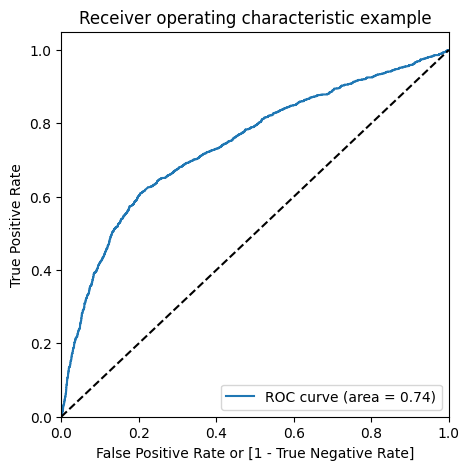

In [14]:
#roc Curve
draw_roc(y_test, svc_y_test_pred_proba)

Inference:
